# SOFC Power Plant Example

This notebook runs the SOFC power plant model over a range of net power outputs from 650 MW to 200 MW. The SOFC model is based on case ANGFC3B in the NETL report "Techno-Economic Analysis of Natural Gas Fuel Cell Plant Configurations" April 2022
https://www.netl.doe.gov/projects/files/TechnoEconomicAnalysisofNaturalGasFuelCellPlantConfigurations_043022.pdf

## Module Imports

In [1]:
import os
import numpy as np
import pandas as pd
import pytest
from IPython.core.display import SVG

import pyomo.environ as pyo
from pyomo.environ import units as pyunits
from pyomo.util.infeasible import log_infeasible_constraints

import idaes
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util as iutil

from sofc import (
    get_model,
    initialize,
    add_tags,
    write_pfd,
    make_stream_table
)
from sofc_costing import (
    get_capital_cost,
    get_fixed_costs,
    get_variable_costs
)

## Make Output Directories

This notebook can produce a large number of output files.  To make it easier to manage, some subdirectories are used to organize output.  This ensures that the directories exist.

In [2]:
# Make a directory if it doesn't exist
def make_directory(path):
    if not os.path.exists(path):
        os.mkdir(path)
    
make_directory("data")
make_directory("data_pfds")
make_directory("data_tabulated")

## Global Solver Settings

Use the IDAES configuration system for solver settings. These will apply to all Ipopt instances created, including the ones created in initialization methods.

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.linear_solver = "ma57"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt.options.ma57_pivtol = 1e-5
idaes.cfg.ipopt.options.ma57_pivtolmax = 0.1
idaes.cfg.ipopt.options.bound_push = 1e-20
solver = pyo.SolverFactory("ipopt")

## Create the SOFC model

Create the SOFC model and initialize it or read the saved initialization if available.  The base SOFC model is configured to match the NGFC report.

In [4]:
def get_base_sofc_model():
    m = get_model()
    save_name = "sofc_init.json.gz"
    if os.path.exists(save_name):
        iutil.from_json(m, fname=save_name, wts=iutil.StoreSpec(suffix=False))
        print("Loading initialized model from json")
    else:
        initialize(m)
        iutil.to_json(m, fname=save_name)
    print("Solving initialized model")
    res = solver.solve(m, tee=True)
    return m

## Design Optimization
Optimize the heat exchanger sizes at the nameplate capacity of 650 MW.

In [5]:
m = get_base_sofc_model()

# add costs
get_capital_cost(m)
get_fixed_costs(m)
get_variable_costs(m)

# setup design optimization problem
m.fs.obj = pyo.Objective(
    expr=m.fs.costing.annualized_tasc + m.fs.costing.total_fixed_OM_cost + m.fs.costing.total_variable_OM_cost[0]
)

# unfix decision vars
m.fs.anode_hx.area.unfix()
m.fs.cathode_hx.area.unfix()
m.fs.air_blower.inlet.flow_mol.unfix()
m.fs.cathode_recycle.split_fraction[0, 'recycle_outlet'].unfix()
m.fs.sofc.OTC.unfix()
m.fs.sofc.OTC.setlb(2.099)
m.fs.sofc.OTC.setub(2.2)

# add sofc operational constraints
@m.fs.Constraint()
def maximum_cell_temperature(fs):
    return m.fs.sofc.max_cell_temperature <= 750

@m.fs.Constraint()
def maximum_cell_temperature_change(fs):
    return m.fs.sofc.deltaT_cell <= 100

# enforce net power = 650 MW
m.fs.net_power_MW = pyo.Var(
    m.fs.time,
    initialize=650,
    bounds=(100, 900),
    units=pyunits.MW)

@m.fs.Constraint(m.fs.time)
def net_power_constraint(fs, t):
    return fs.net_power_MW[t] == pyunits.convert(fs.net_power[t], pyunits.MW)

m.fs.anode_mix.feed_inlet.flow_mol.unfix()
m.fs.net_power_MW.fix(650)

save_name = "sofc_design_opt.json.gz"
if os.path.exists(save_name):
    iutil.from_json(m, fname=save_name, wts=iutil.StoreSpec(suffix=False))
    print("Loading optimized design from json")
else:
    res = solver.solve(m, tee=True)
    iutil.to_json(m, fname=save_name)

Loading initialized model from json
Solving initialized model
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
ma57_pivtol=1e-05
ma57_pivtolmax=0.1
bound_push=1e-20
option_file_name=C:\Users\alxor\AppData\Local\Temp\tmp32ly7xun_ipopt.opt

Using option file "C:\Users\alxor\AppData\Local\Temp\tmp32ly7xun_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a

  25  2.5577089e+02 1.06e-10 8.64e-02  -7.0 9.04e-01    -  1.00e+00 1.00e+00h  1
  26  2.5577089e+02 1.02e-10 3.19e-03  -7.0 7.63e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   2.5577088635098326e+02    2.5577088635098326e+02
Dual infeasibility......:   3.1863689833759113e-03    3.1863689833759112e-01
Constraint violation....:   1.0186340659856796e-10    1.0186340659856796e-10
Complementarity.........:   9.0909091118741548e-08    9.0909091118741548e-08
Overall NLP error.......:   9.0909091118741548e-08    3.1863689833759112e-01


Number of objective function evaluations             = 27
Number of objective gradient evaluations             = 27
Number of equality constraint evaluations            = 27
Number of inequality constraint evaluations          = 27
Number of equality constraint Jacobian evaluations   = 27
Number of inequality constraint Jacobian evaluations = 27
N

## Show PFDs with design optimization results
This displays PFDs in the notebook, and saves them to files.

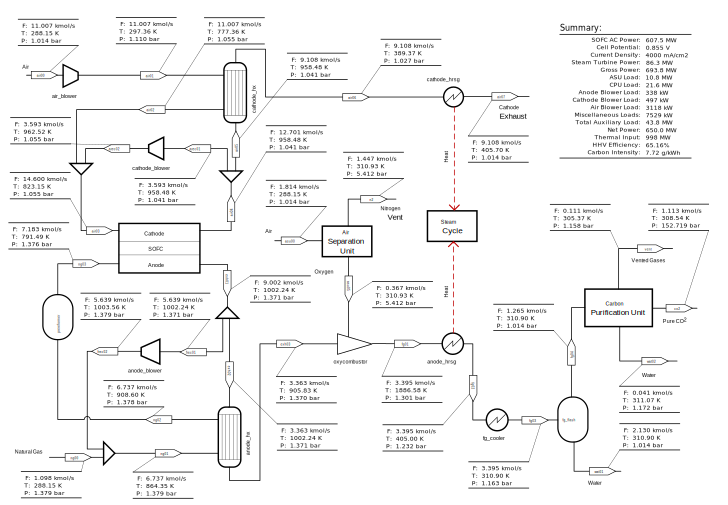

In [6]:
display(SVG(write_pfd(m)))
write_pfd(m, fname="data_pfds/sofc_results.svg")

In [7]:
# record and display results
optimal_anode_hx_area = m.fs.anode_hx.area.value
optimal_cathode_hx_area = m.fs.cathode_hx.area.value

# assert that flowsheet values have not changed from prior runs
assert m.fs.anode_hx.area.value == pytest.approx(2683.16, rel=0.01)
assert m.fs.cathode_hx.area.value == pytest.approx(15135.97, rel=0.01)
assert m.fs.cathode_recycle.split_fraction[0, 'recycle_outlet'].value == pytest.approx(0.2828, rel=0.01)
assert m.fs.air_blower.inlet.flow_mol[0].value == pytest.approx(11.007, rel=0.01)

print("------------------------------------------")
print("Decision Variable Results")
print("------------------------------------------")
print(f"Anode hx area = {m.fs.anode_hx.area.value} ft^2")
print(f"Cathode hx area = {m.fs.cathode_hx.area.value} ft^2")
print(f"Cathode recirculation fraction = {m.fs.cathode_recycle.split_fraction[0, 'recycle_outlet'].value}")
print(f"Cathode air flowrate = {m.fs.air_blower.inlet.flow_mol[0].value} kmol/s")

print("\n")
print("------------------------------------------")
print("Capital Costs")
print("------------------------------------------")
print(f"SOFC modules = MM${m.fs.sofc_modules.costing.total_plant_cost.value}")
print(f"SOFC balance of plant = MM${pyo.value(m.fs.costing.sofc_bop_cost)}")
print(f"Oxycombustor = MM${m.fs.oxycombustor.costing.total_plant_cost.value}")
print(f"Air separation unit = MM${m.fs.asu.costing.total_plant_cost.value}")
print(f"Carbon purification unit = MM${m.fs.cpu_cost.costing.total_plant_cost.value}")
print(f"Feedwater and misc. BOP systems = MM${pyo.value(m.fs.costing.feedwater_bop_cost)}")
print(f"HRSG, ductwork, and stack = MM${pyo.value(m.fs.costing.hrsg_ductwork_and_stack_cost)}")
print(f"Steam turbine generator = MM${pyo.value(m.fs.costing.steam_turbine_cost)}")
print(f"Cooling water system = MM${pyo.value(m.fs.costing.cooling_water_system_cost)}")
print(f"Electric equipment = MM${pyo.value(m.fs.costing.accessory_electric_plant_cost)}")
print(f"Instrumentation and control = MM${pyo.value(m.fs.costing.instrumentation_and_control_cost)}")
print(f"Improvements to site = MM${pyo.value(m.fs.costing.improvements_to_site_cost)}")
print(f"Buildings and structures = MM${pyo.value(m.fs.costing.buildings_and_structures_cost)}")
print("\n")
print(f"Total Plant Cost = MM${m.fs.costing.total_TPC.value}")
print(f"Total Overnight Cost = MM${m.fs.costing.total_overnight_cost.value}")
print(f"Total As Spent Cost = MM${m.fs.costing.total_as_spent_cost.value}")
print(f"Annualized TASC = MM${m.fs.costing.annualized_tasc.value}/year")

print("\n")
print("------------------------------------------")
print("Fixed and Variable O&M Costs")
print("------------------------------------------")
print(f"Annual operating labor = MM${m.fs.costing.annual_operating_labor_cost.value}/year")
print(f"Maintenance labor = MM${m.fs.costing.maintenance_labor_cost.value}/year")
print(f"Admin & support labor = MM${m.fs.costing.admin_and_support_labor_cost.value}/year")
print(f"Property taxes & insurance = MM${m.fs.costing.property_taxes_and_insurance.value}/year")
print(f"Maintenance material cost = MM${m.fs.costing.maintenance_material_cost.value}/year")
print(f"Stack replacement cost = MM${m.fs.costing.stack_replacement_cost.value}/year")
print(f"Total Fixed O&M Cost = MM${m.fs.costing.total_fixed_OM_cost.value}/year")
print(f"Total Variable O&M Cost = MM${m.fs.costing.total_variable_OM_cost[0].value}/year")

------------------------------------------
Decision Variable Results
------------------------------------------
Anode hx area = 2683.160814716269 ft^2
Cathode hx area = 15135.972121852119 ft^2
Cathode recirculation fraction = 0.2828607869917892
Cathode air flowrate = 11.007126050466544 kmol/s


------------------------------------------
Capital Costs
------------------------------------------
SOFC modules = MM$216.35120660710723
SOFC balance of plant = MM$22.16819860587384
Oxycombustor = MM$17.25766113649777
Air separation unit = MM$75.16656941296881
Carbon purification unit = MM$80.17568164876177
Feedwater and misc. BOP systems = MM$78.41974917660735
HRSG, ductwork, and stack = MM$44.923905152961474
Steam turbine generator = MM$50.98302022038935
Cooling water system = MM$32.59760880545304
Electric equipment = MM$67.15738319049841
Instrumentation and control = MM$20.487473627553243
Improvements to site = MM$28.837921346638332
Buildings and structures = MM$12.805970619738082


Total Pla

## Run SOFC Partial Load

This runs the SOFC model at partial load from 650 MW to 200 MW at 5 MW intervals. Results are tabulated for tags in the tags_output tag group in a Pandas data frame.

To run the series, change run_series to True. Running the turndown series takes a while, unless previous saved results are available.

In [8]:
run_series = False
if run_series:
    idaes.cfg.ipopt.options.tol = 1e-6
    idaes.cfg.ipopt.options.mu_init = 1e-3
    solver = pyo.SolverFactory("ipopt")

    # reload the model since capital costs are not important here
    m = get_base_sofc_model()
    get_variable_costs(m)
    add_tags(m)

    # setup operation optimization problem
    m.fs.obj = pyo.Objective(
        expr=m.fs.costing.total_variable_OM_cost[0]
    )

    # fix hx areas to their optimal values
    m.fs.anode_hx.area.fix(optimal_anode_hx_area)
    m.fs.cathode_hx.area.fix(optimal_cathode_hx_area)

    # unfix operating decision vars
    m.fs.air_blower.inlet.flow_mol.unfix()
    m.fs.cathode_recycle.split_fraction[0, 'recycle_outlet'].unfix()

    # add sofc operational constraints
    @m.fs.Constraint()
    def maximum_cell_temperature(fs):
        return m.fs.sofc.max_cell_temperature <= 750

    @m.fs.Constraint()
    def maximum_cell_temperature_change(fs):
        return m.fs.sofc.deltaT_cell <= 100
    
    m.fs.sofc.current_density.setlb(1000)

    # create var to enforce net power
    m.fs.net_power_MW = pyo.Var(
        m.fs.time,
        initialize=650,
        bounds=(100, 900),
        units=pyunits.MW)

    @m.fs.Constraint(m.fs.time)
    def net_power_constraint(fs, t):
        return fs.net_power_MW[t] == pyunits.convert(fs.net_power[t], pyunits.MW)

    m.fs.anode_mix.feed_inlet.flow_mol.unfix()

    df = pd.DataFrame(columns=m._tags_output.table_heading())

    for p in range(650, 199, -20):
        print(f"Solving for {p} MW net power")
        m.fs.net_power_MW.fix(p)

        turndown_ratio = p/650
        m.fs.sofc.current_density.fix(turndown_ratio*4000)

        fname = f"data/sofc_{int(p)}.json.gz"
        if os.path.exists(fname):
            iutil.from_json(m, fname=fname, wts=iutil.StoreSpec(suffix=False))
        else:
            res = solver.solve(m, tee=True, symbolic_solver_labels=True)
            iutil.to_json(m, fname=fname)

        df.loc[m._tags_output["net_power"].value] = m._tags_output.table_row(numeric=True)

    df.to_csv("data_tabulated/sofc.csv")